In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import HTML, display, Image

import warnings
warnings.filterwarnings('ignore')

datadir = '../../datasets/Hands_on_5_Spapros'

# Advanced evaluation

In this tutorial we evaluate probesets in finer detail: besides the summary values for each metric (see basic evaluation tutorial) we can get e.g. per gene and per cell type information of each evaluation.

## Import packages and setup

In [3]:
import pandas as pd
import scanpy as sc
import spapros as sp
import matplotlib.pyplot as plt
import os

In [4]:
sc.settings.verbosity = 1
sc.logging.print_header()
print(f"spapros=={sp.__version__}")

spapros==0.1.5


## Load dataset

In [5]:
adata = sc.datasets.pbmc3k()
adata_tmp = sc.datasets.pbmc3k_processed()

# Get infos from the processed dataset
adata = adata[adata_tmp.obs_names, adata_tmp.var_names]
adata.obs['celltype'] = adata_tmp.obs['louvain']
adata.obsm['X_umap'] = adata_tmp.obsm['X_umap']
del adata_tmp

# Preprocess counts and get highly variable genes
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="cell_ranger", n_top_genes=1000)

adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'celltype'
    var: 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_umap'

## 2. Set up the ProbesetEvaluator

As described in the basic evaluation tutorial Spapros provides a set of evaluation metrics that measure the performance of a gene set.

By default the `ProbesetEvaluator` sets the argument `scheme="quick"`, which means that only the metrics that are quickly calculated are included, which are:

>- neighborhood similarity (knn)
>- cell type (forest) classification
>- marker correlation (if marker list given: `marker_list="../path/to/marker_list.csv"`)
>- gene redundancy (correlation)

Through setting `scheme="full"`, additionally the following metric is calculated:
>- clustering similarity (nmi)


Alternatively, you can specify `scheme="custom"` and `metrics=custom_list` where `custom_list` is a list of the metrics of interest.

In [6]:
# initialize a ProbesetEvaluator
evaluator = sp.ev.ProbesetEvaluator(
    adata,
    scheme="full",
    marker_list=os.path.join(datadir, "/pbmc3k_marker_list.csv"),
    verbosity=2,
    results_dir="spapros_evaluation_advanced"
)

The pbmc3k_marker_list.csv includes the following data:

| | **CD4 T cells** | **CD14+ Monocytes** | **B cells** | **CD8 T cells** | **NK cells** | **FCGR3A+ Monocytes** | **Dendritic Cells** | **Megakaryocytes** |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| **Marker 1** | IL7R | CD14 | MS4A1 | CD8A | GNLY | FCGR3A | FCER1A | NAPA-AS1 |
| **Marker 2** | None | LYZ | None | None | NKG7 | MS4A7 | CST3 | PPBP |

## 3.  Run evaluation methods

The central method to run evaluations is `ProbesetEvaluator.evaluate_probeset()`, which needs to be invoked once for each probe set.
All results are stored as class variables.
The `set_id` has to be specified in each iteration. Otherwise, the results will be overwritten.

The selection of all probesets will take about 10 minutes. Instead, you can also load the results directly. 
```python
# select reference probesets with basic selection methods
selections = sp.se.select_reference_probesets(adata, n=20)

# Take Spapros genes from basic selection tutorial
genes = [
    'PF4', 'HLA-DPB1', 'FCGR3A', 'GZMB', 'CCL5', 'S100A8', 'IL32', 'HLA-DQA1', 'NKG7', 'AIF1', 'CD79A', 'LTB', 'TYROBP',
    'HLA-DMA', 'GZMK', 'HLA-DRB1', 'FCN1', 'S100A11', 'GNLY', 'GZMH'
]

selection_df = pd.DataFrame()
selection_df["spapros"] = genes
for probeset_name, probeset_df in selections.items():
    selection_df[probeset_name] = probeset_df.index[probeset_df["selection"]].to_list()
    

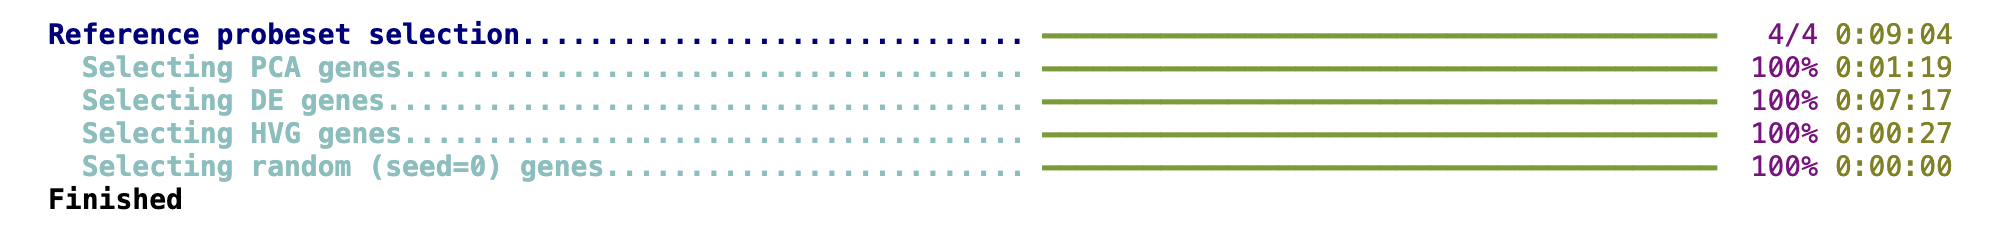

In [7]:
# load the results 
selection_df = pd.read_csv(os.path.join(datadir, 'spapros_evaluation_advanced_df.csv'), index_col=0)

In [8]:
selection_df

,PCA,DE,HVG,random (seed=0),spapros
0,CTSS,S100A8,FGFBP2,MDS2,S100A11
1,S100A11,FCER1G,IGJ,MARCKSL1,S100A8
2,S100A8,GNLY,PF4,WARS2,FCGR3A
3,SELL,PF4,PPBP,CD247,GNLY
4,TRAF3IP3,PPBP,GZMK,GPR35,PF4
5,ID2,GZMA,GZMA,RNF168,GZMK
6,GNLY,LTB,HLA-DQA1,ADD1,LTB
7,GPX1,LST1,PRF1,ISOC1,AIF1
8,ARL6IP5,HLA-DPA1,MS4A1,PURA,HLA-DRB1
9,UBE2D2,HLA-DPB1,GZMH,FCN1,HLA-DQA1


Now start the evaluation for each of the collected probesets. There are also precomputed results for this. 

In [9]:
# copy precomputed results to writable working dir
! cp -r $datadir/spapros_evaluation_advanced* . 

In [10]:
# start the evaluation for each of the collected probesets
for probeset_name, gene_list in selection_df.items():
    evaluator.evaluate_probeset(gene_list, set_id=probeset_name)

SPAPROS PROBESET EVALUATION:                                                                     0:00:02
Shared metric computations................................ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   5/5 0:00:01
  Loading shared computations for cluster_similarity...... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100% 0:00:00
  Loading shared computations for knn_overlap............. ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100% 0:00:00
  Loading shared computations for gene_corr............... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100% 0:00:01
  Loading shared computations for marker_corr............. ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100% 0:00:00
Probeset specific pre computations........................ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   5/5 0:00:00
  Loading pre computations for cluster_similarity......... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100% 0:00:00
  Loading pre computations for knn_overlap................ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100% 0:00:00
Final probeset specific computations...................... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   5/5 0:00:00
  Loading final computations for cluster_similarity....... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100% 0:00:00
  Loading final computations for knn_overlap.............. ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100% 0:00:00
  Loading final computations for forest_clfs.............. ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100% 0:00:00
  Loading final computations for gene_corr................ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100% 0:00:00
  Loading final computations for marker_corr.............. ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100% 0:00:00
FINISHED

There are maximally four steps to calculate for each metric:
1. shared computations: this step is only needed once for all probe sets (e.g. clusterings on the reference data that includes all genes)
2. pre computations: this step is run for each probe set, but it's independent of the shared results of step 1
3. main computations: this step is run for each probe set and depends on the shared results of step 1 (if there was a step 1 for a given metric) and potentially the pre results of step 2
4. summary computations: extract the final metric value as a summary statistic

In the above progress bars you can see that the shared computations take longer for the first probe set. For the following probe sets, the shared computations are reused.

Not all metrics include all 4 steps. E.g. forest classification simply has a main computation step, as it doesn't require any shared computations.

In [11]:
evaluator.summary_results

,cluster_similarity nmi_5_20,cluster_similarity nmi_21_60,knn_overlap mean_overlap_AUC,forest_clfs accuracy,forest_clfs perct acc > 0.8,gene_corr 1 - mean,gene_corr perct max < 0.8,marker_corr per marker,marker_corr per celltype,marker_corr per marker mean > 0.025
PCA,0.674919,0.531528,0.293958,0.889057,0.904067,0.820372,1.000000,0.454319,0.555655,0.573841
DE,0.711467,0.548200,0.160030,0.917495,0.958829,0.757868,0.792178,0.672017,0.863489,0.863489
HVG,0.492561,0.409155,0.056494,0.819224,0.720651,0.840755,0.900000,0.591106,0.766929,0.753666
random (seed=0),0.242861,0.255746,0.023869,0.575790,0.003333,0.976067,1.000000,0.229733,0.290810,0.290023
spapros,0.719880,0.553635,0.167581,0.923674,0.988360,0.772479,0.993647,0.703430,0.902092,0.902092


Explanations of the metrics:

**Variation recovery metrics**:
- *cluster_similarity nmi_5_20*: Assess the similarity of clustering the dataset on all genes vs just the selected gene set. Clusterings are calculated with different leiden resolutions to genertate clusterings of n = 5 to 20 clusters. The NMI is calculated between the clusterings of the full dataset and the gene set. Finally the average NMI over the different n's is calculated. This metric measures how well the clustering structure of the dataset is recovered with a gene subset. As n is chosen to be between 5 and 20 this metric assess clustering structure on a coarse level.
- *cluster_similarity nmi_21_60*: Same as above but with n = 21 to 60 clusters. This metric assesses clustering structure on a finer level.
- *knn_overlap mean_overlap_AUC*: Similar to cluster_similarity this metric assesses how well the dataset's structure is recovered with a gene subset. It looks at even finer variation recovery than cluster_similarity nmi_21_60 as it assesses the overlap of each cell's k nearest neighbors of the full dataset knn graph and the gene set knn graph. 

**Cell type classification metrics**:
- *forest_clfs accuracy*: This metric assesses how well a random forest classifier can predict cell types based on the gene set. The metric is the mean accuracy of the classifier over all cell types.
- *forest_clfs perct acc > 0.8*: This metric assesses how many cell types can be predicted with an accuracy of at least 0.8. More specifically the transformation function is not a sharp step function at 0.8 but instead at step function with a linear increase from 0 to 1 between 0.75 and 0.85 (i.e. smoothed thresholding). The metric gives an idea about how many cell types can be identified with high confidence with the given gene set.

**Gene redundancy metrics**:
- *gene_corr 1 - mean*: Mean over maximum correlations of each gene with all other genes. This metric assesses how redundant the gene set is. Note that the actual value is 1 - the mean correlations which means the higher the value the less redundant the gene set is.
- *gene_corr perct max < 0.8*: Percentage of genes that have a maximum correlation of less than 0.8 with all other genes. This metric gives an idea about how many genes show unique expression profiles in the gene set. The reasoning behind introducing this metric with the 0.8 threshold is that genes that are only "somewhat correlated" (e.g. r=0.5) could still encode for different information and thus be useful in a gene set, while genes that are highly correlated (e.g. r=0.9) are likely redundant. Note however, that redundancy is not necessarily bad, as it can be used to increase robustness of the gene set.

## 4. Visualize the evaluation results

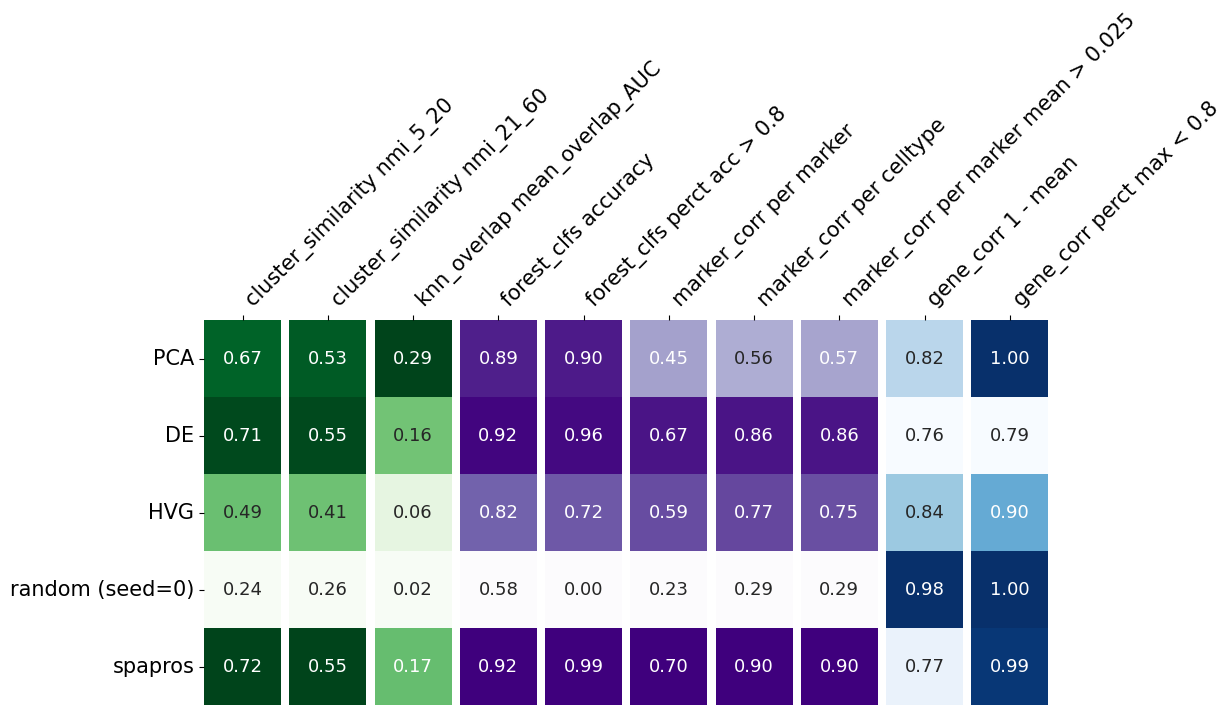

In [12]:
#evaluator.summary_statistics(set_ids=selections.keys())
evaluator.plot_summary()

I this plot, each row summarizes the evaluation metrics of a given gene set.
The metrics evaluating the variability recovery are shown in the green columns (1-3).
The clustering similarity (coarse level clustering: 5-20, fine level clustering: 21-60) is evaluated by the normalized mutual information (NMI) of the clustering of the selected probeset and the clustering on the full gene set. High scores means that the cells build similar cluster on the gene subset as on the full gene set.


Both NMI values are highest for the pca based selection, which indicates that this method recovers the variability best in this comparison.

Even more fine grained variation recovery is measured with the third column (knn_overlap). It measures the neighbors overlap of the knn graphs of the full gene set and the respective probeset. 

The subsequent purple columns (4-8) indicate the performance of each selection method with respect to cell type identification.
Column 4 contains the mean classification accuracy of a random forest prediction over cell types. This quantifies the overall classification success while column 5 provides an estimate for the percentage of reliably captured cell types, i.e. the average of a smoothed thresholding of classification performance around 0.8 for each cell type.
The other 3 purple columns (6-8) derive from the comparison of the correlation within the selected probeset with the correlation within the marker list.

The last two, blue columns (9, 10) evaluate the correlation within a selected probeset. If genes with highly correlated expression are selected, the information content could also be provided by just one of them.


### Evaluations beyond summary metrics

The summary metrics are useful to get an overview of the performance of the gene sets. However, to understand the performance in more detail, we can look into more specific evaluation scores that were calculated on the run and still accessible in the `ProbesetEvaluator` object.

#### Cell type identification

To see and compare how well each cell type can be classified with different gene sets we plot the cell type classification confusion matrices. The confusion matrix shows how many cells of a given cell type were classified as another cell type. The diagonal of the matrix shows the correct classification rate. The better the classification the more the diagonal is filled with high values.

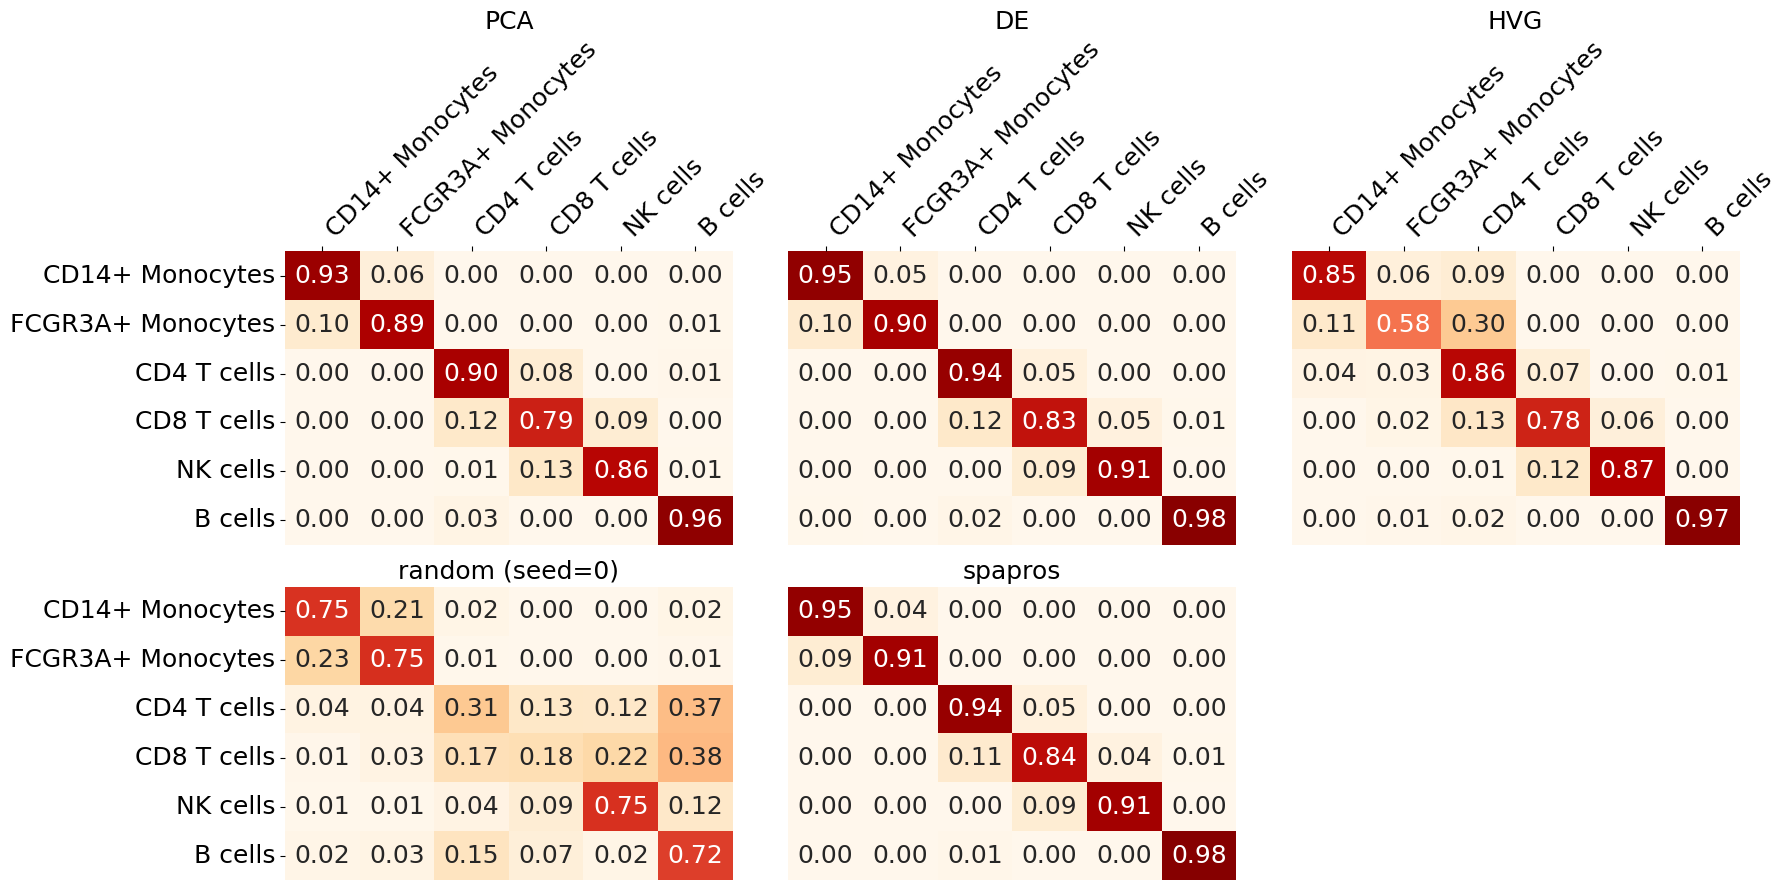

In [13]:
evaluator.plot_confusion_matrix()

We can oberserve that CD8 T cells are the most difficult to classify across gene sets. The highest classification accuracy for all cell types in this example is achieved with the Spapros selection.

#### Gene redundancy

We can look into the coexpression patterns of genes by looking at the correlation matrix of the selected genes. Ideally we find a few correlative modules. If there is a correlative module that's very large compared to the others, then a high capacity of the gene set is wasted on redundant information.

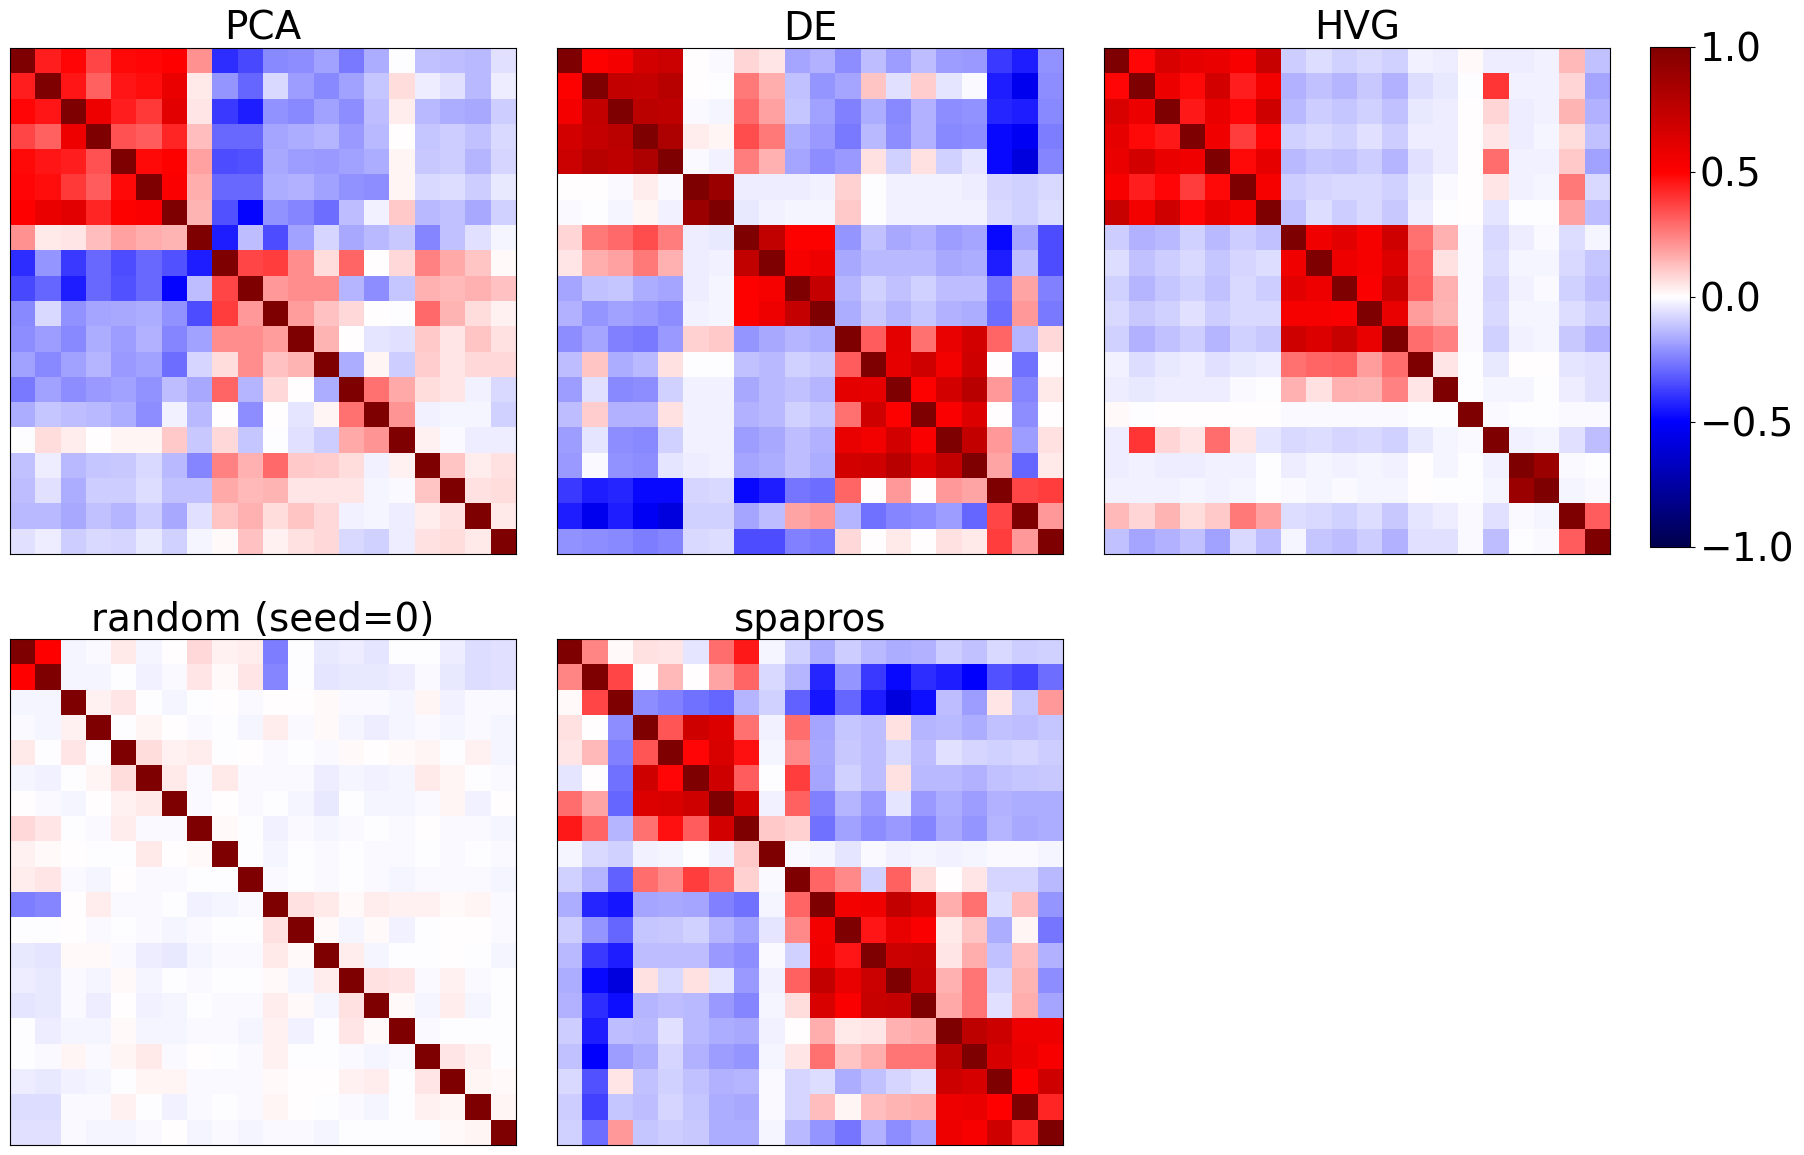

In [14]:
evaluator.plot_coexpression()

#### Clustering similarity

For the clustering similarity we can look at the similarity (nmi) between the gene set and the full gene set for different total numbers of cluster. This can give us an idea if a gene set is for example more capable to recover coarse clustering structure than fine clustering structure. For larger datasets such behavior could be expected e.g. for DE selections (coarse clustering focused) and PCA based selections (fine clustering focused). Note that this fine level analysis is mainly useful when comparing gene sets. 

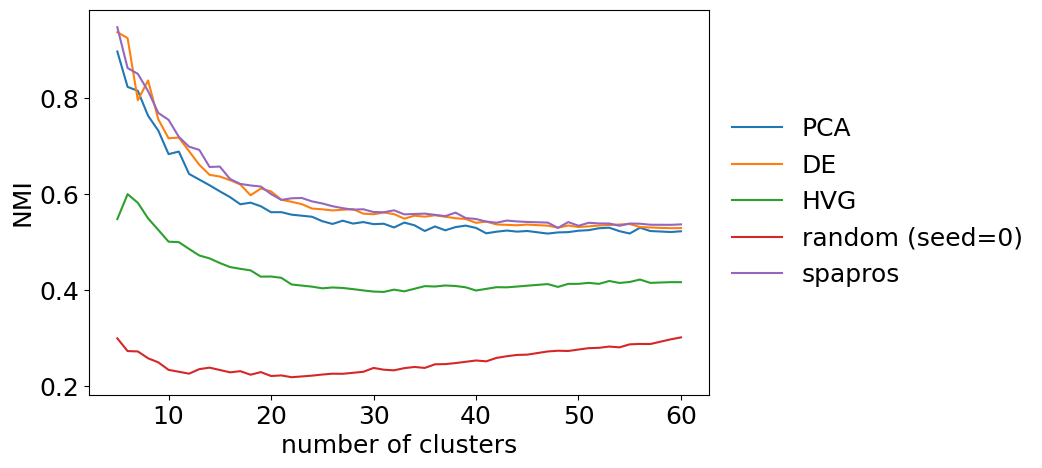

In [15]:
evaluator.plot_cluster_similarity()

#### Neighborhood similarity

The detailed evaluation on neighborhood similarity is more of a sanity check than providing additional information. We can plot the overlap for different k's of k nearest neighbors graphs. The summary metric is the mean over all k. The metric should show a very stable increase with k for each gene set.

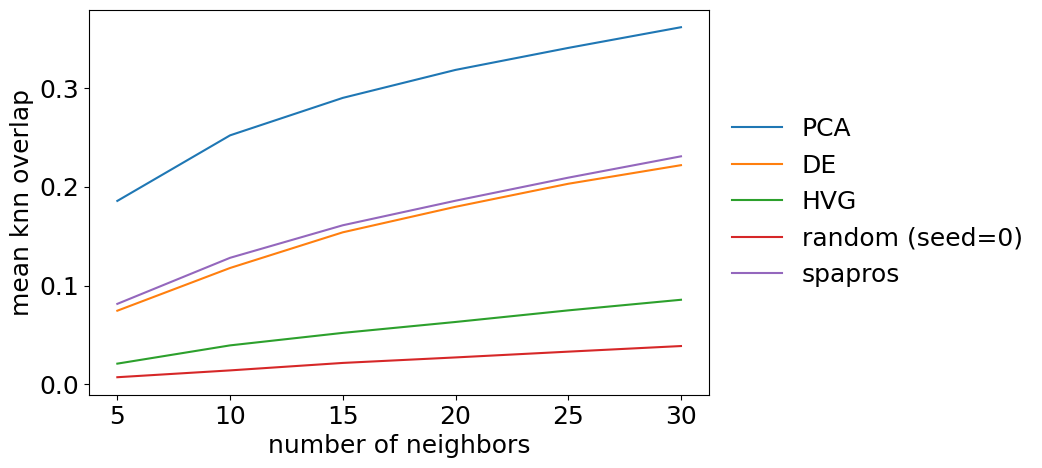

In [16]:
evaluator.plot_knn_overlap()